In [1]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

In [2]:
from core.cluster_validation import generate_neigbhourhood_groups, colored_crosstab
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [5]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [9]:
region_id = 'freiburg'

tessellations_dir = graph_dir = '../data/freiburg//'
chars_dir = '../data/freiburg/chars/'

In [10]:
primary = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

In [11]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [12]:
# import lonboard
# layer = lonboard.PolygonLayer.from_geopandas(tessellation, opacity=0.15)
# m = lonboard.Map([layer])
# m

### Generate context

In [13]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1]) + 1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1] * output_vals))

    istart = 0
    for g in range(ngroups):
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend - 1] == rows[iend]:
            iend += 1

        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):
            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals * c

            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index + 1] = np.nan
                result[g, res_index + 2] = np.nan
                continue

            lower, med, higher = np.nanpercentile(col_vals, (10, 50, 90))
            result[g, res_index] = lower
            result[g, res_index + 1] = med
            result[g, res_index + 2] = higher

        # # go to next group
        istart = iend
    return result

In [14]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(
        np.empty((values.shape[0], values.shape[1] * output_vals)), index=ids
    )

    for source in np.array_split(rows, n_splits):
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step

        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(
            rows_to_pass, columns_to_pass, partial_vals, output_vals
        )

        final_result.iloc[source, :] = partial_res

    return final_result

In [15]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [16]:
## Discard disconnected components and focus on a single component only.
## doesnt make a big difference.

In [17]:
graph.component_labels.value_counts()

component labels
0     35118
9       776
10      636
2        81
3        20
14       17
23       16
6        14
13        8
11        7
21        5
5         4
15        4
8         3
7         2
24        2
4         2
26        2
1         2
17        1
19        1
20        1
16        1
22        1
12        1
25        1
18        1
Name: count, dtype: int64

cluster only the data from the first component

In [18]:
# data = primary.loc[component_labels]
# data_graph = graph.subgraph(component_labels)
# component_labels = graph.component_labels.copy()
# component_labels = component_labels[component_labels == 0].index.values

cluster only buildings tessellation cells

In [19]:
# data = primary.loc[primary.index >= 0]
# data_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])

In [20]:
data = primary
data_graph = graph

In [21]:
spatial_lag = 3
spatial_lag

3

In [22]:
%%time
context = parallel_higher_order_context(
    data, data_graph, k=spatial_lag, n_splits=10, output_vals=3
)

CPU times: user 21.6 s, sys: 1.52 s, total: 23.1 s
Wall time: 6.11 s


In [23]:
context.columns = np.concatenate(
    [(c + "_lower", c + "_median", c + "_higher") for c in primary.columns]
)

In [24]:
# context.to_parquet(f'../data/freiburg/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [25]:
context.to_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [ ]:
# X = context

In [ ]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)
# r = higher.describe(primary['sdbAre'], statistics=['median'])['median']
# from pandas.testing import assert_series_equal
# assert_series_equal(context['sdbAre_median'], r, check_names=False)

# r.duplicated().sum()

### Data preprocessing

In [ ]:
tess_groups = generate_validation_groups(tessellation, include_random_sample=True)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [ ]:
## no spatial lag
X = np.nan_to_num(StandardScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

In [ ]:
## no spatial lag
X = np.nan_to_num(RobustScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

In [ ]:
## no spatial lag
X = np.nan_to_num(PowerTransformer().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

In [ ]:
### only medians

In [ ]:
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

In [ ]:
X = np.nan_to_num(
    RobustScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

In [ ]:
X = np.nan_to_num(
    PowerTransformer().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")] + 1
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

In [ ]:
## clip medians to -10, 10 standard deviations
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
X = X.clip(-10, 10)
check_score(X, tess_groups)

In [ ]:
# all features with lag

In [ ]:
# no standardisation
X = np.nan_to_num(context)
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

In [ ]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

In [ ]:
X = np.nan_to_num(RobustScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

In [ ]:
X = np.nan_to_num(PowerTransformer().fit_transform(context + 1))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

In [ ]:
## clip to -10, 10 standard deviations
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
X = X.clip(-10, 10)
check_score(X, tess_groups)

In [ ]:
context["sdbAre_lower"].describe()

In [ ]:
desc = X.describe()

In [ ]:
desc.loc[["25%", "50%", "75%", "max"]]

In [ ]:
corrs = context.corr().abs()
upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))

In [ ]:
corrs_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
corrs_to_drop

In [ ]:
X_no_corr = X.drop(columns=corrs_to_drop)
X_no_corr.shape, check_score(X_no_corr, tess_groups)

In [ ]:
# corrs_to_drop = []
# X_no_corr = X.drop(columns=corrs_to_drop)
# X_no_corr.shape, check_score(X_no_corr, tess_groups)

In [ ]:
# X.describe()

In [ ]:
desc = X_no_corr.describe()
to_drop = desc.columns[(desc.loc["max"] - desc.loc["min"]) < 0.5].values
to_drop

In [ ]:
X_different = X_no_corr.drop(columns=to_drop)
X_different.shape, check_score(X_different, tess_groups)

In [ ]:
X_no_duplicates = X_different[~X_different.duplicated()]
X_no_duplicates.shape, check_score(X_no_duplicates, tess_groups)

In [ ]:
# tessellation[X_different.duplicated(keep=False)].explore()

In [ ]:
# plotting = tessellation.loc[X_different[X_different.duplicated(keep=False)].index.values]
# plotting['sdbAre_lower'] = X_different[X_different.duplicated(keep=False)]['sdbAre_lower']
# plotting = plotting.sort_values('sdbAre_lower')
# plotting['sdbAre_lower']

In [ ]:
# layer = PolygonLayer.from_geopandas(
#     gdf=plotting.reset_index()[['geometry', 'index', 'sdbAre_lower']],
#     opacity=.15
# )
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [ ]:
# tessellation.loc[graph[250196].index.values].reset_index().explore()

In [ ]:
# tessellation.loc[higher[21149].index.values, ].explore()

In [ ]:
# tessellation.loc[higher[271717].index.values, ].explore()

In [ ]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [ ]:
# primary.loc[higher[271717].index.values, 'sdbAre'].median(), primary.loc[higher[271714].index.values, 'sdbAre'].median()

In [ ]:
# primary.loc[higher[271717].index.values, 'sdbAre'].describe()

In [ ]:
# primary.loc[higher[271714].index.values, 'sdbAre'].describe()

In [ ]:
# r = dict([])
# for idx in higher[271717].index.values:
#     r[idx] = (primary.loc[higher[idx].index.values, 'sdbAre'].median())

In [ ]:
# dict(sorted(r.items(), key=lambda item: item[1]))

In [ ]:
# remove singletons

In [ ]:
singletons = graph.unique_ids[graph.cardinalities == 1]

In [ ]:
# tessellation.loc[singletons].explore()

In [ ]:
X_no_singletons = X_no_duplicates[~X_no_duplicates.index.isin(singletons)]
X_no_singletons.shape, check_score(X_no_singletons, tess_groups)

In [ ]:
# remove empty space

In [ ]:
X_buildings = X_no_singletons[X_no_singletons.index >= 0]
X_buildings.shape, check_score(X_buildings, tess_groups)

In [ ]:
X_train = X_buildings
X_train.shape, check_score(X_train, tess_groups)

In [ ]:
X_train.describe().loc["max"].describe()

In [ ]:
# X_train.to_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [ ]:
X_train = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

In [ ]:
spatial_lag = 3
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
X_train = X_train[X_train.index >= 0]
X_train = X_train.clip(-10, 10)

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')
X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')

### UMAP tests

In [ ]:
# spatial_lag = 1


# X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

# # lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')


# X_train = X_train.join(lag[[c for c in lag.columns if '_median' not in c]], how='inner')

# # X_train = X_train.join(lag, how='inner')


# X_train.shape

In [ ]:
X_train = primary.join(context, how='inner')

In [ ]:
X_train = X_train[X_train.index >= 0]


vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# X_train = X_train.clip(-10, 10)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
X_train.shape

In [ ]:
tess_groups = generate_neigbhourhood_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=2_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [ ]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist, metric='euclidean'):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
        metric=metric
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

In [ ]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.10, metric='euclidean')

In [ ]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.10, metric='cosine')

In [ ]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.0, metric='sqeuclidean')

In [ ]:
# for n_neighbors in [15, 25, 50, 100]:
#     for n_components in [5, 10, 15]:
#         show_nn(
#             n_neighbors=n_neighbors,
#             n_components=n_components,
#             n_epochs=500,
#             min_dist=0.1,
#         )

In [ ]:
# for n_neighbors in [30, 100]:
#     for n_components in [5, 10, 15]:
#         for min_dist in [0.0, 0.05, 0.1]:
#             show_nn(
#                 n_neighbors=n_neighbors,
#                 n_components=n_components,
#                 n_epochs=500,
#                 min_dist=min_dist,
#             )

In [42]:
assert not X_train.duplicated().any()

In [44]:
reducer = umap.UMAP(n_neighbors=25, n_components=2, min_dist=0, metric='euclidean', verbose=True)
embedding = reducer.fit_transform(X_train)

UMAP(min_dist=0, n_neighbors=25, verbose=True)
Wed Jul 31 19:51:52 2024 Construct fuzzy simplicial set
Wed Jul 31 19:51:52 2024 Finding Nearest Neighbors
Wed Jul 31 19:51:52 2024 Building RP forest with 14 trees
Wed Jul 31 19:51:52 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Wed Jul 31 19:51:53 2024 Finished Nearest Neighbor Search
Wed Jul 31 19:51:53 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jul 31 19:52:04 2024 Finished embedding


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

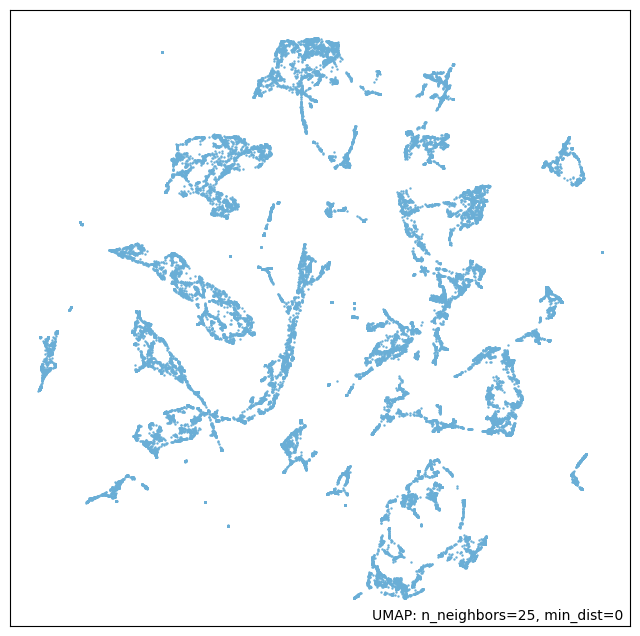

In [45]:
umap.plot.points(reducer)

### Umap visualisations


In [ ]:
viz_reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, verbose=True, metric='sqeuclidean')
viz_embedding = viz_reducer.fit_transform(X_train)

In [ ]:
umap.plot.points(viz_reducer)

In [ ]:
embedding_df = pd.DataFrame(embedding[tess_groups_ilocs, :3], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

In [ ]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")

gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig, ax = plt.subplots(figsize=(10, 10))

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :2]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
ax.legend()

In [ ]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()

In [ ]:
# ax.view_init(45, 45)
# fig

In [ ]:
# ax.view_init(45, 90)
# fig

In [ ]:
# ax.view_init(45, 135)
# fig

In [ ]:
davies_bouldin_score(embedding[tess_groups_ilocs, :], tess_groups.values)

In [ ]:
umap.plot.points(viz_reducer)

In [ ]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="pca")

In [ ]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="vq")

In [ ]:
local_dims = umap.plot.diagnostic(viz_reducer, diagnostic_type="local_dim")

In [ ]:
### paint the UMAP embeddings by prague district

In [ ]:
czech_admin = (
    gpd.read_file("../../notebooks/data/MAP_CUR_MAP_MESTSKECASTI_P.zip")
    .sort_values("KOD_MC")
    .reset_index(drop=True)
)
admin_id, tess_id = tessellation.loc[X_train.index].sindex.query(
    czech_admin.geometry.to_crs(tessellation.crs), predicate="intersects"
)
import glasbey

gb_cols = glasbey.extend_palette(Set3_12.hex_colors, palette_size=max(admin_id) + 1)
czech_admin["color"] = gb_cols
labels = pd.Series("Bohemia", index=X_train.index)
labels.iloc[tess_id] = czech_admin.iloc[admin_id]["NAZEV_MC"].values
cmap = dict(zip(czech_admin["NAZEV_MC"].values, gb_cols, strict=False))
cmap["Bohemia"] = "#ffffff"

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
umap.plot.points(
    viz_reducer,
    labels=labels,
    background="black",
    color_key=cmap,
    show_legend=False,
    ax=ax,
)

In [ ]:
umap.plot.connectivity(viz_reducer, show_points=True)

In [ ]:
np.save(embedding)

In [ ]:
np.save("data/umap_prague_k7_n30_dim15.npy", embedding)

In [ ]:
embedding.shape

In [ ]:
np.load("data/umap_prague_k7_n30_dim15.npy").shape

In [ ]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(embedding[tess_groups_ilocs, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label)

In [ ]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [ ]:
# tessellation.loc[X_different[X_different.duplicated()].index.values].explore()

### PCA tests and comparison

In [ ]:
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.decomposition import PCA

In [ ]:
%%time
pca_reducer = PCA(n_components=50)
pca_embedding = pca_reducer.fit_transform(X_train)

In [ ]:
pca_reducer.explained_variance_ratio_.cumsum()

In [ ]:
embedding_df = pd.DataFrame(pca_embedding[tess_groups_ilocs], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

In [ ]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :10]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)

ax.legend()

In [ ]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

In [ ]:
ax.view_init(45, 45)
fig

In [ ]:
ax.view_init(45, 90)
fig

In [ ]:
ax.view_init(45, 135)
fig

In [ ]:
davies_bouldin_score(pca_embedding[tess_groups_ilocs, :5], tess_groups.values)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(pca_embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

In [ ]:
colored_crosstab(tess_groups.values, kmeans_label)

In [ ]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(pca_embedding[:, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

In [ ]:
colored_crosstab(tess_groups.values, kmeans_label)

In [ ]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [ ]:
# np.save('../data/umap.npy', embedding)


In [ ]:
# embedding = np.load('../data/umap.npy')

### HDBSCAN

In [ ]:
## EVOC


In [ ]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [ ]:
min_cluster_size = 25

In [ ]:
%%time
sklearn_tree = KDTree(embedding)

In [ ]:
%%time
numba_tree = kdtree_to_numba(sklearn_tree)

In [ ]:
%%time
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)

In [ ]:
sorted_mst = edges[np.argsort(edges.T[2])]

In [ ]:
%%time
linkage_tree = mst_to_linkage_tree(sorted_mst)

In [ ]:
condensed_tree = condense_tree(linkage_tree, min_cluster_size=100)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [ ]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(tess_groups.values, clusters[tess_groups_ilocs])

In [ ]:
np.unique(clusters, return_counts=True)

In [ ]:
davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

In [ ]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [ ]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters

In [ ]:
from core.cluster_validation import get_color
colors = get_color(clusters)

In [ ]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

In [ ]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [ ]:
layer.get_fill_color = get_color(cluster_layers[4])

In [ ]:
from evoc.clustering import binary_search_for_n_clusters

In [ ]:
res = binary_search_for_n_clusters(X_train.values, 10, min_samples=n_neighbors)

In [ ]:
res

In [ ]:
%%time

from evoc.clustering import build_cluster_layers

# input_embedding = embedding
input_embedding = embedding
min_num_clusters = 4
min_samples = n_neighbors
base_min_cluster_size = min_samples
next_cluster_size_quantile = .8

cluster_layers, membership_strengths = build_cluster_layers(
            input_embedding,
            min_clusters=min_num_clusters,
            min_samples=min_samples,
            base_min_cluster_size=base_min_cluster_size,
            next_cluster_size_quantile=next_cluster_size_quantile,
)

In [ ]:
n_points_clustered_per_layer = [
    # np.sum(layer >= 0) for layer in cluster_layers
    np.mean(layer_strengths[layer_clusters >= 0]) for layer_clusters, layer_strengths in zip(cluster_layers, membership_strengths)
]
best_layer = np.argmax(n_points_clustered_per_layer)
best_layer

In [ ]:
n_points_clustered_per_layer

#### Assign noise points to nearest cluster


In [ ]:
from fast_hdbscan.numba_kdtree import parallel_tree_query
from fast_hdbscan.numba_kdtree import parallel_tree_query

In [ ]:
clustered_data = X_train[clusters >= 0]
unclustered_data = X_train[clusters == -1]

In [ ]:
%%time
sklearn_tree = KDTree(clustered_data)
numba_tree = kdtree_to_numba(sklearn_tree)

In [ ]:
%%time
distances, knns = parallel_tree_query(numba_tree, np.array(unclustered_data, order='C'), k=1)

In [ ]:
pd.Series(distances[:, 0]).describe()

In [ ]:
new_labels = clusters.copy()

## which cluster should the noise points be assigned to
assignments = clusters[np.where(clusters >= 0)[0][knns[:, 0]]]

new_labels[new_labels == -1] = assignments

In [ ]:
np.save('../data/sample_cluster_labels.npy', new_labels)

In [ ]:
to_dissolve = tessellation.loc[X_train.index]

In [ ]:
to_dissolve['cluster'] = new_labels

In [ ]:
%%time
disolved = to_dissolve.dissolve('cluster')

In [ ]:
disolved.to_parquet('../data/sample_clusters.parquet')

#### assign duplicates to nearest cluster...

In [ ]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')

In [ ]:
with sc:
    display(m)

## KMEANS

In [ ]:
## append individual original data

# embedding = X_train
# embedding = X_train[[c for c in X_train.columns if 'median' in c]]

# to_add = primary.loc[X_train.index]
# to_add = np.nan_to_num(StandardScaler().fit_transform(to_add))
# to_add = pd.DataFrame(to_add, columns=primary.columns, index=X_train.index)
# to_add = to_add.clip(-10, 10)
# check_score(X, tess_groups)

# embedding = pd.concat((embedding, to_add), axis=1)

In [ ]:
for k in range(2, 20):
    kmeans_label = (
    KMeans(n_clusters=k)
        .fit(embedding)
        .labels_
    )

    print(k, adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs]), davies_bouldin_score(X_train, kmeans_label))

In [ ]:
# kmeans_label = (
#     KMeans(n_clusters=18)
#         .fit(pca_embedding)
#         .labels_
#     )

In [ ]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = kmeans_label

In [ ]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


if plotting["label"].max() > 12:
    gb_cols = glasbey.extend_palette(
        Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
    )
else:
    gb_cols = Set3_12.hex_colors

gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [ ]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

In [ ]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [ ]:
%%time
imps = get_feature_importance(X_train, kmeans_label)

In [ ]:
colored_crosstab(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [ ]:
selected = [0, 3, 4, 5, 14]
imps[np.concat([(f'cluster_{c}', f'cluster_{c}_vals') for c in selected])].iloc[:20, ]

In [ ]:
np.unique(np.concatenate(imps.iloc[:20].values)).shape

In [ ]:
%%time
imps = get_feature_importance(X_train.iloc[tess_groups_ilocs], tess_groups.values)

In [ ]:
used_keys['ltbIBD']

In [ ]:
imps

## Hierarchical 

In [ ]:
embedding = X_train

In [46]:
embedding = reducer.embedding_

In [47]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score

In [48]:
q1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
q1 = q1.higher_order(k=3, lower_order=True, diagonal=True)

# q1 = graph

clustering_graph = q1.subgraph(X_train.index.values).transform('B').sparse

In [49]:
clusterer = AgglomerativeClustering(linkage='ward',
                                    connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)

In [50]:
%%time
model = clusterer.fit(embedding)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 27 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: user 7.41 s, sys: 80 ms, total: 7.49 s
Wall time: 5.3 s


In [51]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

In [52]:
linkage_matrix = get_linkage_matrix(model)

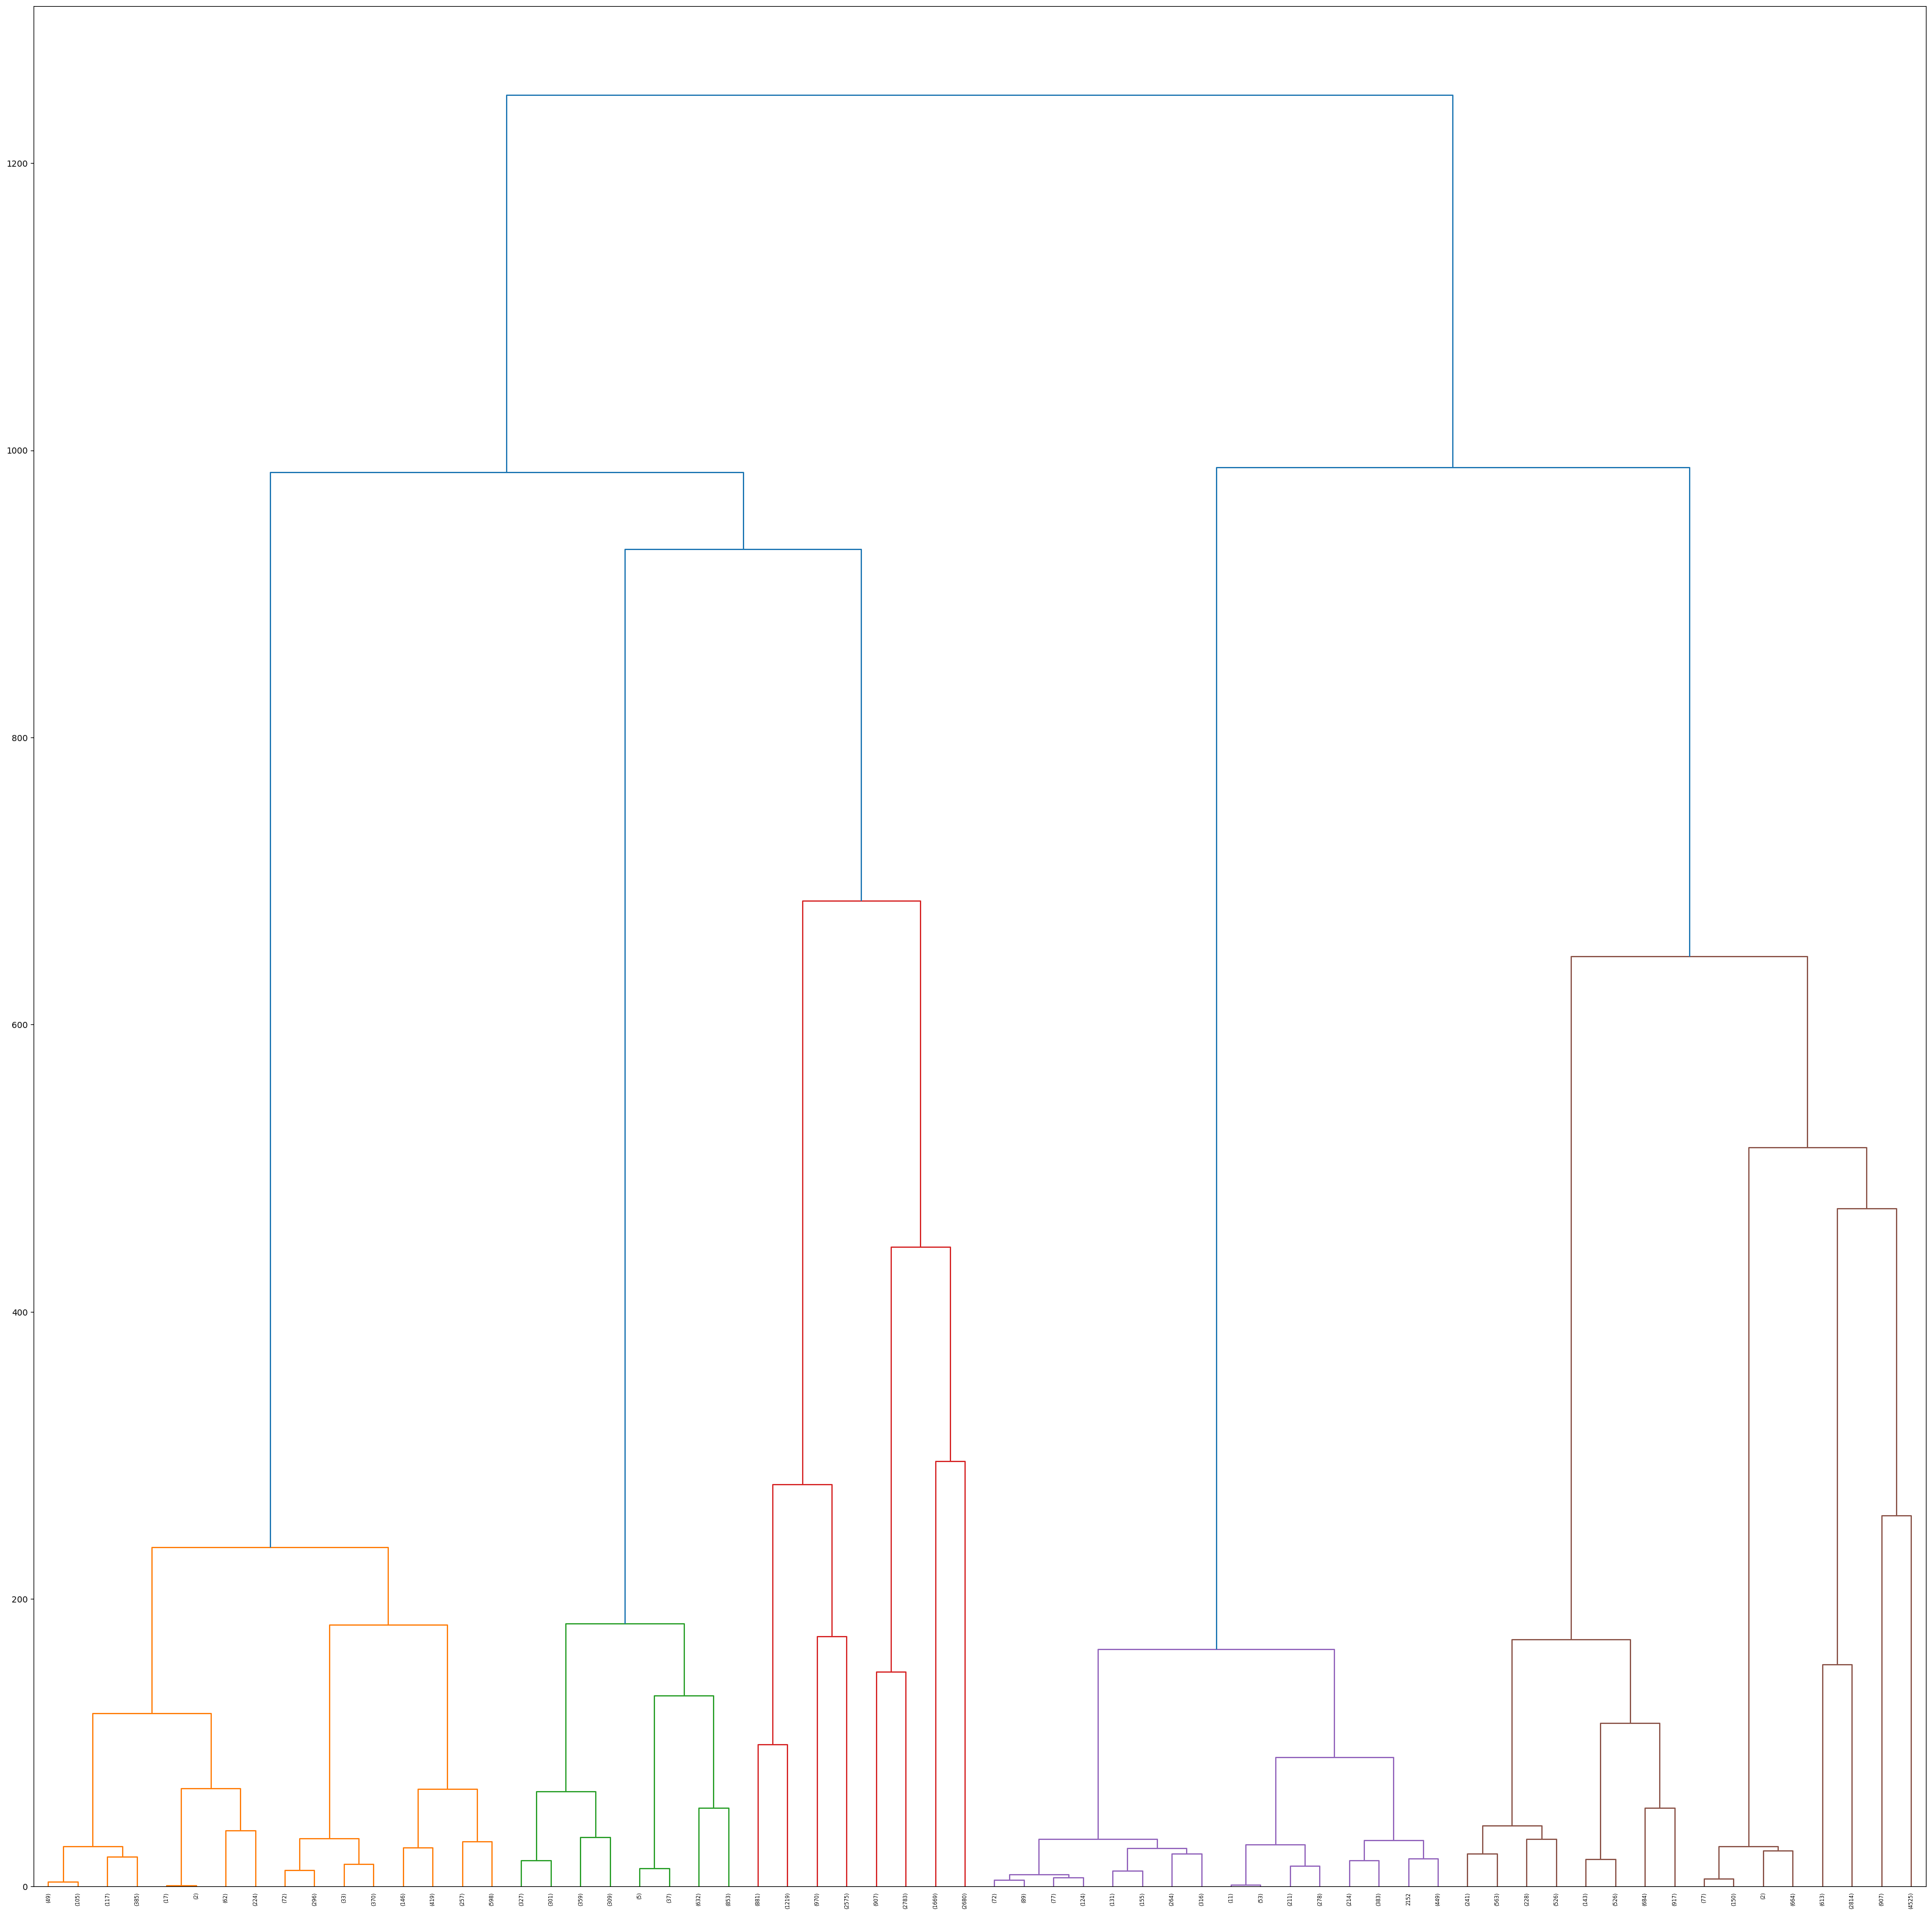

In [53]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [55]:
for t in range(50, 800, 50):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          # adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(X_train, r),
          calinski_harabasz_score(X_train, r)
         )

50  -  3.5471318799809257 375.6664084645414
100  -  3.721423965873348 470.0581675334533
150  -  4.105514086952385 513.1965027318491
200  -  4.267200145383798 600.3173384683571
250  -  4.047700044886316 667.5580994298883
300  -  4.143110871547471 688.0402235138519
350  -  4.143110871547471 688.0402235138519
400  -  4.143110871547471 688.0402235138519
450  -  4.154990944363187 683.8376377905672
500  -  4.106640100371632 720.9259611751281
550  -  4.246264396721982 791.06787337862
600  -  4.246264396721982 791.06787337862
650  -  4.25877415874191 833.0267929513459
700  -  4.533999144964662 753.8363969699094
750  -  4.533999144964662 753.8363969699094


In [54]:
from sklearn.metrics import calinski_harabasz_score

In [56]:
clusters = fcluster(linkage_matrix, t=500, criterion='distance')

In [57]:
np.unique(clusters, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([3152, 2823, 5645, 8039, 2828, 3828,  893, 8859]))

In [58]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters

In [59]:
%%time
import lonboard
plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 666 ms, sys: 43.8 ms, total: 710 ms
Wall time: 709 ms


In [60]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [61]:
from core.cluster_validation import get_color

In [68]:
clusters = fcluster(linkage_matrix, t=300, criterion='distance')

In [69]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([3152, 2823, 5645, 3690, 4349, 2828, 3828,  893, 3427, 5432]))

In [70]:
layer.get_fill_color = get_color(clusters)

In [ ]:

cdf = plotting.join(X_train, how='inner')

In [ ]:
cdf['label'] = clusters

In [ ]:
cdf = cdf.dissolve(by='label', aggfunc='mean')

In [ ]:
# cdf.explore(column=cdf.index.values, categorical=True)

In [ ]:
cdf.to_parquet('../data/freiburg/clusters/clusters_freiburg_ward_300.parquet')